In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import random

In [7]:
# Set a seed value
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## LSTM for Cluster

In [8]:
# read files:
price_df = pd.read_csv("gold_data/Gold Futures Historical Data.csv")
cluster_df = pd.read_csv("gold-dataset-clustered-v4.csv")

price_df["Change %"] = price_df["Change %"].str.rstrip("%").astype(float)

In [9]:
price_df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/06/2019,"1,462.50","1,478.20","1,481.50","1,461.00",0.68K,-1.20
1,12/05/2019,"1,480.30","1,477.60","1,482.70","1,475.90",0.64K,0.19
2,12/04/2019,"1,477.50","1,480.40","1,487.00","1,474.00",0.88K,-0.28
3,12/03/2019,"1,481.60","1,465.50","1,484.70","1,462.80",1.40K,1.04
4,12/02/2019,"1,466.40","1,467.30","1,468.50","1,457.40",1.40K,-0.24
...,...,...,...,...,...,...,...
4995,02/22/2000,307.70,307.60,309.40,304.20,25.89K,0.13
4996,02/18/2000,307.30,303.30,307.80,302.00,19.38K,1.15
4997,02/17/2000,303.80,305.30,312.50,300.00,11.81K,-0.39
4998,02/16/2000,305.00,304.20,306.00,299.70,56.34K,0.30


In [10]:
cluster_df

,Unnamed: 0,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment,Topic,Macro_Group,Probabilities,Dominant_Macro_Group,Topic_Label
0,0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative,33,16,"[-27.631021115928547, -27.631021115928547, 1.0...",2,Gold Climbs in Trading
1,1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative,4,3,"[-27.631021115928547, -27.631021115928547, 1.0...",2,Global Investment & Rate Impact
2,2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive,28,7,"[-27.631021115928547, -27.631021115928547, -27...",5,Gold Trading Momentum Continues
3,3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,none,23,11,"[-27.631021115928547, -27.631021115928547, -27...",9,Gold Market Turning Points
4,4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative,-1,-1,"[-4.196897111170408, -5.228338252285433, -2.99...",15,noise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10565,10565,07-01-2013,https://www.moneycontrol.com/news/business/mar...,gold seen falling from 3-week high this week,0,0,1,0,1,0,negative,0,15,"[-27.631021115928547, -27.631021115928547, -27...",10,Gold Near Monthly Lows
10566,10566,27-09-2018,https://www.metalsdaily.com/link/284468/domini...,dominic frisby : now looks like a good time to...,1,0,0,0,0,1,positive,1,3,"[-4.0906712565573615, -5.106674554783079, -2.5...",4,Global Investment & Rate Impact
10567,10567,03-03-2017,https://www.thehindubusinessline.com/markets/g...,Gold heading for worst week since November on ...,0,0,1,0,1,0,negative,0,15,"[-3.7496462953932133, -4.533892448909454, -2.3...",10,Gold Near Monthly Lows
10568,10568,11-06-2008,http://www.marketwatch.com/story/august-gold-u...,august gold up $7.60 at $878.80 an ounce on nymex,1,0,0,0,1,0,positive,21,3,"[-3.4146375360315675, -4.1595826528082815, -1....",2,Global Investment & Rate Impact


In [19]:
import pandas as pd

# --- Step 1: Parse dates safely ---
cluster_df["Dates"] = pd.to_datetime(
    cluster_df["Dates"], dayfirst=True, errors="coerce"
)
price_df["Date"] = pd.to_datetime(price_df["Date"], errors="coerce")

# --- Step 2: Drop rows with invalid dates ---
cluster_df = cluster_df.dropna(subset=["Dates"])
price_df = price_df.dropna(subset=["Date"])

# --- Step 3: Convert to date only (no time component) ---
cluster_df["Dates"] = cluster_df["Dates"].dt.date
price_df["Date"] = price_df["Date"].dt.date

# --- Step 4: Group by Dates and Topic_Label, count headline frequency ---
daily_counts = (
    cluster_df.groupby(["Dates", "Topic_Label"]).size().reset_index(name="count")
)

# --- Step 5: Pivot to get frequency embedding ---
frequency_embedding = daily_counts.pivot(
    index="Dates", columns="Topic_Label", values="count"
).fillna(0)

# --- Step 6: Sanitize string column names for modeling ---
frequency_embedding.columns = [
    f"topic_{str(col).lower().replace(' ', '_').replace('&', 'and').replace(',', '')}"
    for col in frequency_embedding.columns
]

# --- Step 7 (Optional): Reset index if needed ---
frequency_embedding = frequency_embedding.reset_index()

In [20]:
frequency_embedding

,Dates,topic_china_fed_and_gold_focus,topic_comex_gold_closing_prices,topic_early_gold_trading_activity,topic_economic_data_and_gold_performance,topic_global_cues_and_gold_stability,topic_global_investment_and_rate_impact,topic_gold_climbs_in_trading,topic_gold_holds_as_data_releases,topic_gold_market_turning_points,topic_gold_near_monthly_lows,topic_gold_price_support_levels,topic_gold_prices_and_metal_shares,topic_gold_settlement_price_correction,topic_gold_spot_price_outlook,topic_gold_trading_momentum_continues,topic_market_rates_and_gold_demand,topic_rate_hikes/cuts_price_impact,topic_time_sensitive_prediction,topic_noise
0,2000-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2000-03-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2000-04-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2000-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3667,2019-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3668,2019-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3669,2019-01-30,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3670,2019-01-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
frequency_embedding.to_csv("cluster_embedding_output.csv", index=False)

In [16]:
frequency_embedding.describe()

,topic_china_fed_and_gold_focus,topic_comex_gold_closing_prices,topic_early_gold_trading_activity,topic_economic_data_and_gold_performance,topic_global_cues_and_gold_stability,topic_global_investment_and_rate_impact,topic_gold_climbs_in_trading,topic_gold_holds_as_data_releases,topic_gold_market_turning_points,topic_gold_near_monthly_lows,topic_gold_price_support_levels,topic_gold_prices_and_metal_shares,topic_gold_settlement_price_correction,topic_gold_spot_price_outlook,topic_gold_trading_momentum_continues,topic_market_rates_and_gold_demand,topic_rate_hikes/cuts_price_impact,topic_time_sensitive_prediction,topic_noise
count,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000,3672.000000
mean,0.080065,0.042756,0.021242,0.234749,0.130719,0.755447,0.039216,0.040033,0.027778,0.193627,0.096133,0.025871,0.067266,0.053105,0.022059,0.053105,0.050926,0.018791,0.880719
std,0.290811,0.212832,0.153363,0.534214,0.383270,1.029183,0.211591,0.210792,0.166007,0.496605,0.345049,0.160480,0.260118,0.231446,0.150558,0.242930,0.257535,0.143604,1.086776
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,3.000000,2.000000,3.000000,5.000000,3.000000,7.000000,2.000000,2.000000,2.000000,5.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,2.000000,11.000000


In [ ]:
cluster_df["Dates"] = pd.to_datetime(
    cluster_df["Dates"], dayfirst=True, errors="coerce"
)

price_df["Date"] = pd.to_datetime(price_df["Date"], errors="coerce")

In [7]:
cluster_df.shape

(10570, 16)

In [ ]:
merged_df = pd.merge(cluster_df, price_df, left_on="Dates", right_on="Date", how="left")

In [9]:
merged_df.columns

Index(['Unnamed: 0', 'Dates', 'URL', 'News', 'Price Direction Up',
       'Price Direction Constant', 'Price Direction Down', 'Asset Comparision',
       'Past Information', 'Future Information', 'Price Sentiment', 'Topic',
       'Macro_Group', 'Probabilities', 'Dominant_Macro_Group', 'Topic_Label',
       'Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'],
      dtype='object')

In [10]:
subset_df = merged_df[
    ["Dates", "Topic_Label", "Date", "Price", "Open", "High", "Low", "Vol.", "Change %"]
]
# we have 703 rows with no data to it. Needs to be invested into
sum(subset_df["Price"].isna())

703

In [ ]:
subset_df = subset_df[subset_df["Price"].isna() != True]

In [12]:
subset_df

,Dates,Topic_Label,Date,Price,Open,High,Low,Vol.,Change %
0,2016-01-28,Gold Climbs in Trading,2016-01-28,"1,116.10","1,126.20","1,126.40","1,110.20",151.22K,0.03
1,2017-09-13,Global Investment & Rate Impact,2017-09-13,"1,328.00","1,336.20","1,340.50","1,324.50",306.37K,-0.35
2,2016-07-26,Gold Trading Momentum Continues,2016-07-26,"1,320.80","1,315.50","1,324.40","1,313.60",203.41K,0.10
3,2018-02-28,Gold Market Turning Points,2018-02-28,"1,317.90","1,318.90","1,323.70","1,316.70",263.80K,-0.05
4,2017-09-06,noise,2017-09-06,"1,339.00","1,345.00","1,347.70","1,336.40",309.35K,-0.41
...,...,...,...,...,...,...,...,...,...
10565,2013-01-07,Gold Near Monthly Lows,2013-01-07,"1,646.30","1,656.30","1,663.00","1,642.60",140.82K,-0.16
10566,2018-09-27,Global Investment & Rate Impact,2018-09-27,"1,185.50","1,196.80","1,200.40","1,184.20",0.34K,-0.75
10567,2017-03-03,Gold Near Monthly Lows,2017-03-03,"1,226.50","1,234.80","1,236.70","1,223.00",272.29K,-0.52
10568,2008-06-11,Global Investment & Rate Impact,2008-06-11,882.90,871.20,885.90,870.00,103.59K,1.34


In [13]:
subset_df.shape

(9867, 9)

In [14]:
change_pct = subset_df["Change %"].values.reshape(-1, 1)
change_pct

array([[ 0.03],
       [-0.35],
       [ 0.1 ],
       ...,
       [-0.52],
       [ 1.34],
       [ 0.55]])

In [15]:
len(change_pct)

9867

In [16]:
# one hot encode the topic
from sklearn.preprocessing import OneHotEncoder

topic_labels = subset_df["Topic_Label"].values.reshape(-1, 1)
topic_labels

array([['Gold Climbs in Trading'],
       ['Global Investment & Rate Impact'],
       ['Gold Trading Momentum Continues'],
       ...,
       ['Gold Near Monthly Lows'],
       ['Global Investment & Rate Impact'],
       ['Global Investment & Rate Impact']], dtype=object)

In [17]:
topic_encoder = OneHotEncoder(sparse_output=False)
topic_encoded = topic_encoder.fit_transform(topic_labels)
topic_encoded.shape

(9867, 19)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_change_pct = scaler.fit_transform(change_pct)
combined_features = np.hstack((scaled_change_pct, topic_encoded))
combined_features.shape

(9867, 20)

In [ ]:
# Create sequences from the scaled data
def create_sequences_multifeature(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i : i + window])
        # prediction is only for % change
        y.append(data[i + window][0])
    return np.array(X), np.array(y)


window_size = 30
X, y = create_sequences_multifeature(combined_features, window_size)

In [20]:
X.shape

(9837, 30, 20)

In [ ]:
# Split into training and test sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Make sure types are all the same
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [22]:
X[1]

array([[-0.32508493,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.07531503,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.05815162,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.37847159,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [24]:
def directional_accuracy(actual, predicted):
    correct = np.sum(np.sign(actual) == np.sign(predicted))
    return (correct / len(actual)) * 100

In [25]:
# LSTM

n_features = X.shape[2]  # -> one hot encoding and 1 for % change

lstm_model = Sequential(
    [
        LSTM(units=64, return_sequences=False, input_shape=(window_size, n_features)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1),
    ]
)

# model compile
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
lstm_model.summary()

# Train
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2,
)

# Predict
lstm_y_pred_scaled = lstm_model.predict(X_test).flatten()

# Inverse transform predictions (so we can evaluate)
lstm_y_pred_copies = np.repeat(lstm_y_pred_scaled.reshape(-1, 1), 1, axis=1)
lstm_y_test_copies = np.repeat(y_test.reshape(-1, 1), 1, axis=1)

lstm_y_pred = scaler.inverse_transform(lstm_y_pred_copies)[:, 0]
lstm_y_test_orig = scaler.inverse_transform(lstm_y_test_copies)[:, 0]

# Evaluation metrics for LSTM
lstm_mae = mean_absolute_error(lstm_y_test_orig, lstm_y_pred)
print("LSTM MAE:", lstm_mae)

lstm_mae_percentage = (lstm_mae / np.mean(np.abs(lstm_y_test_orig))) * 100
print("LSTM MAE Percentage:", lstm_mae_percentage)

lstm_dir_acc = directional_accuracy(lstm_y_test_orig, lstm_y_pred)
print("LSTM Directional Accuracy (%):", lstm_dir_acc)

lstm_r2 = r2_score(lstm_y_test_orig, lstm_y_pred)
print("LSTM R²:", lstm_r2)

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,873 (93.25 KB)

 Trainable params: 23,873 (93.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
246/246 - 2s - 6ms/step - loss: 0.9644 - val_loss: 1.1617
Epoch 2/50
246/246 - 1s - 4ms/step - loss: 0.9615 - val_loss: 1.1633
Epoch 3/50
246/246 - 1s - 4ms/step - loss: 0.9612 - val_loss: 1.1635
Epoch 4/50
246/246 - 1s - 4ms/step - loss: 0.9606 - val_loss: 1.1609
Epoch 5/50
246/246 - 1s - 4ms/step - loss: 0.9585 - val_loss: 1.1655
Epoch 6/50
246/246 - 1s - 4ms/step - loss: 0.9586 - val_loss: 1.1635
Epoch 7/50
246/246 - 1s - 4ms/step - loss: 0.9561 - val_loss: 1.1662
Epoch 8/50
246/246 - 1s - 4ms/step - loss: 0.9543 - val_loss: 1.1665
Epoch 9/50
246/246 - 1s - 4ms/step - loss: 0.9528 - val_loss: 1.1679
Epoch 10/50
246/246 - 1s - 4ms/step - loss: 0.9501 - val_loss: 1.1664
Epoch 11/50
246/246 - 1s - 4ms/step - loss: 0.9475 - val_loss: 1.1663
Epoch 12/50
246/246 - 1s - 4ms/step - loss: 0.9451 - val_loss: 1.1661
Epoch 13/50
246/246 - 1s - 4ms/step - loss: 0.9393 - val_loss: 1.1677
Epoch 14/50
246/246 - 1s - 4ms/step - loss: 0.9376 - val_loss: 1.1710
Epoch 15/50
246/246 - 1s - 4m

Compare the above metrics with this baseline:

- LSTM MAE: 0.7164145708084106

- LSTM MAE Percentage: 106.2194

- LSTM Directional Accuracy (%): 48.18913480885312

- LSTM R²: -0.11850190162658691

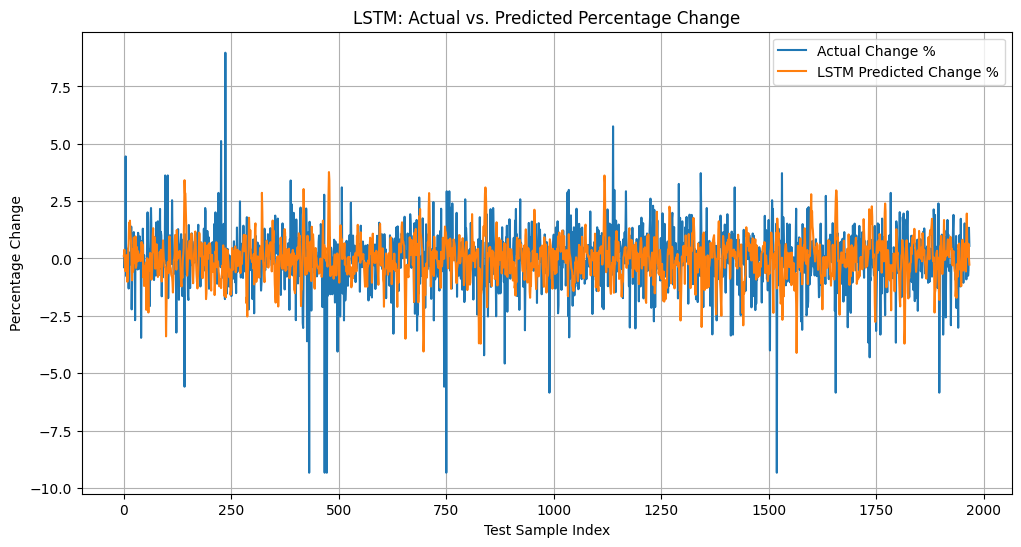

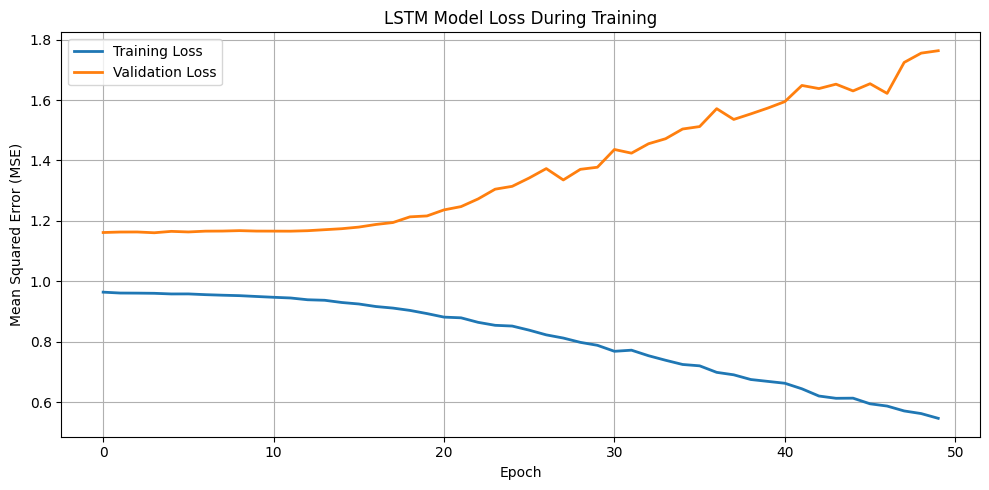

In [26]:
# Plot Actual v Predicted
plt.figure(figsize=(12, 6))
plt.plot(lstm_y_test_orig, label="Actual Change %")
plt.plot(lstm_y_pred, label="LSTM Predicted Change %")
plt.title("LSTM: Actual vs. Predicted Percentage Change")
plt.xlabel("Test Sample Index")
plt.ylabel("Percentage Change")
plt.legend()
plt.grid(True)
plt.show()

# Plot LSTM model loss
plt.figure(figsize=(10, 5))
plt.plot(lstm_history.history["loss"], label="Training Loss", linewidth=2)
plt.plot(lstm_history.history["val_loss"], label="Validation Loss", linewidth=2)
plt.title("LSTM Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

LSTM Precision: 0.5333
LSTM Recall: 0.5202


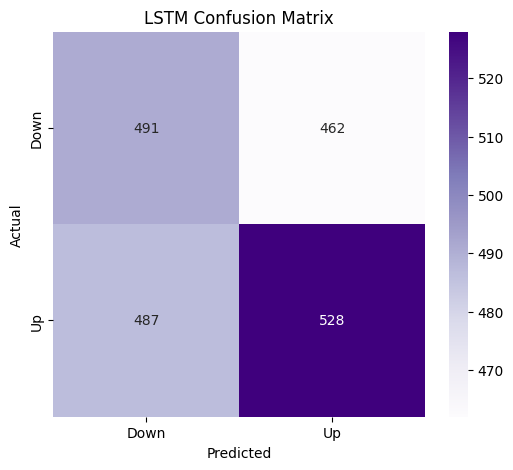

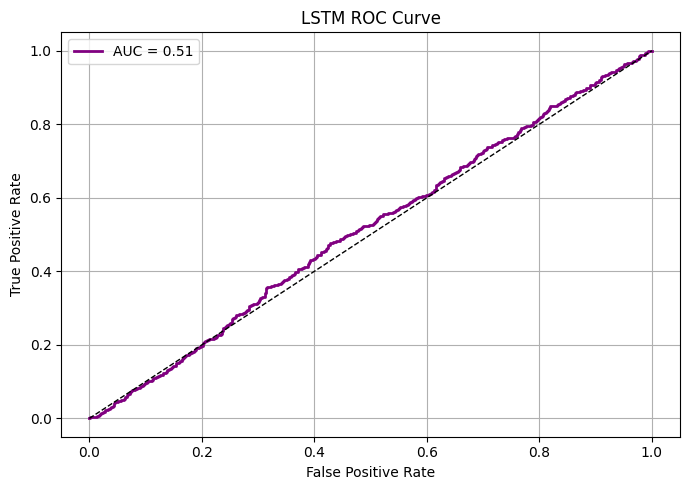

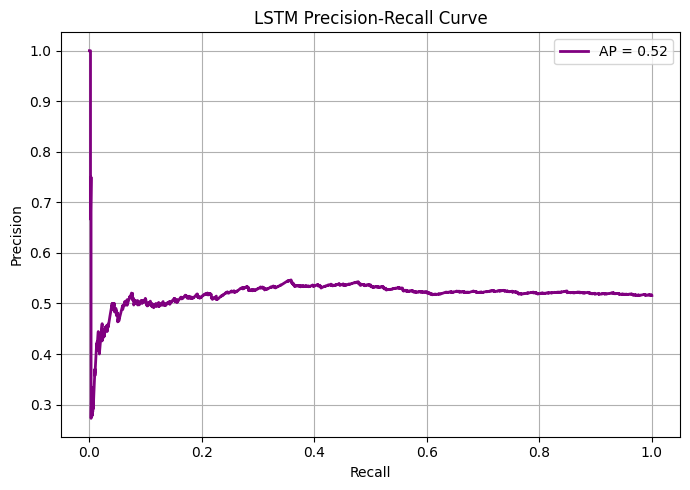

In [27]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
import seaborn as sns
import matplotlib.pyplot as plt

# Convert true and predicted % changes to 1 or 0
lstm_y_test_bin = (lstm_y_test_orig > 0).astype(int)
lstm_y_pred_bin = (lstm_y_pred > 0).astype(int)

# Precision and Recall
lstm_precision = precision_score(lstm_y_test_bin, lstm_y_pred_bin)
lstm_recall = recall_score(lstm_y_test_bin, lstm_y_pred_bin)
print(f"LSTM Precision: {lstm_precision:.4f}")
print(f"LSTM Recall: {lstm_recall:.4f}")

# Confusion Matrix
cm = confusion_matrix(lstm_y_test_bin, lstm_y_pred_bin)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=["Down", "Up"],
    yticklabels=["Down", "Up"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LSTM Confusion Matrix")
plt.show()

# Normalize predictions to simulate probability for ROC/PR curves
lstm_y_pred_proba = (lstm_y_pred - lstm_y_pred.min()) / (
    lstm_y_pred.max() - lstm_y_pred.min()
)

# ROC Curve
fpr, tpr, _ = roc_curve(lstm_y_test_bin, lstm_y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="purple", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(
    lstm_y_test_bin, lstm_y_pred_proba
)
ap_score = average_precision_score(lstm_y_test_bin, lstm_y_pred_proba)
plt.figure(figsize=(7, 5))
plt.plot(
    recall_vals,
    precision_vals,
    label=f"AP = {ap_score:.2f}",
    color="purple",
    linewidth=2,
)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LSTM Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()